In [22]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from parsers import parse_poses3d

In [23]:
pickle_filename = "16_GZ.pickle"   # 改成你的文件名
data_path = os.path.join("data", pickle_filename)

with open(data_path, "rb") as handle:
    data = pickle.load(handle)

print(f"总帧数: {len(data)}")
print("示例 keys:", data[0].keys())


总帧数: 33409
示例 keys: dict_keys(['poses3d', 'poses2d', 'activities', 'num_people', 'rgb_frame_number', 'pc', 'raw_fids', 'radar_session_datetime', 'wallclock', 'PoseNDF_score2d', 'PoseNDF_score3d'])


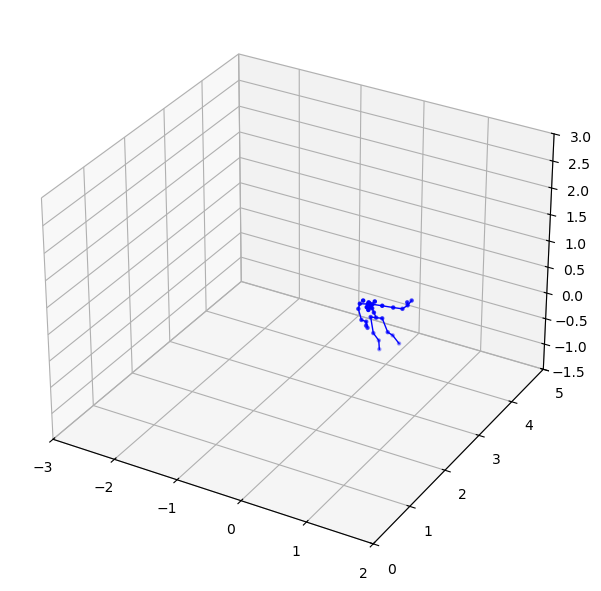

In [24]:
frame_idx = 5000
frame = data[frame_idx]
poses3d_raw = parse_poses3d(frame['poses3d'])

if poses3d_raw is not None and len(poses3d_raw) == 1:
    pose = poses3d_raw[0][None, ...]  # (1,32,4)
    empty_pc = np.zeros((0,6), dtype=float)  # ⚠️ cloud 需要6列
    from plot_utils import plot_pc_3d
    plot_pc_3d(empty_pc, pose)

else:
    print("No single-person pose detected.")


In [25]:
all_poses = []
for idx, frame in enumerate(data):
    poses3d_raw = parse_poses3d(frame['poses3d'])
    if poses3d_raw is not None and len(poses3d_raw) == 1:   # 单人
        all_poses.append(poses3d_raw[0])   # (32,4)
    else:
        all_poses.append(np.zeros((32,4))) # 没检测到人 → 补零

all_poses = np.stack(all_poses, axis=0)    # (T,32,4)
print("Final shape:", all_poses.shape)


Final shape: (33409, 32, 4)


In [26]:
# 去掉 conf 列
all_xyz = all_poses[..., :3]   # (T,32,3)

# 保存为 .npy
save_path = os.path.join("data", "poses_16GZ.npy")
np.save(save_path, all_xyz)

print(f"已保存: {save_path}")

已保存: data\poses_16GZ.npy


In [27]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from parsers import parse_poses3d

In [28]:
pickle_filename = "17_JP.pickle"   # 改成你的文件名
data_path = os.path.join("data", pickle_filename)

with open(data_path, "rb") as handle:
    data = pickle.load(handle)

print(f"总帧数: {len(data)}")
print("示例 keys:", data[0].keys())


总帧数: 36546
示例 keys: dict_keys(['poses3d', 'poses2d', 'activities', 'num_people', 'rgb_frame_number', 'pc', 'raw_fids', 'radar_session_datetime', 'wallclock', 'PoseNDF_score2d', 'PoseNDF_score3d'])


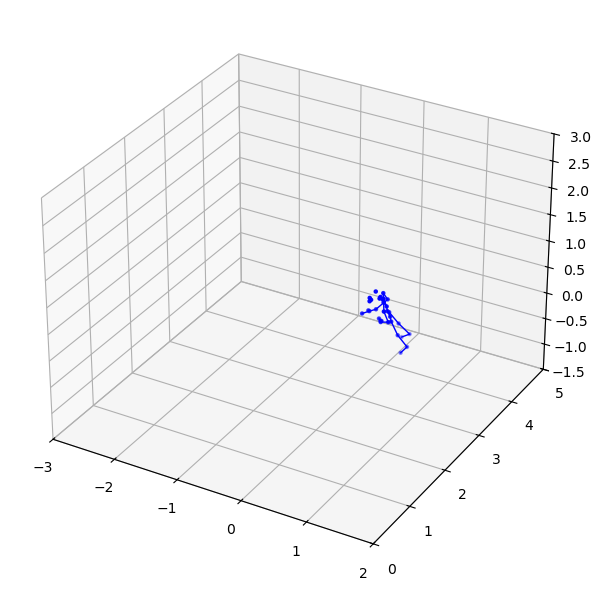

In [29]:
frame_idx = 5000
frame = data[frame_idx]
poses3d_raw = parse_poses3d(frame['poses3d'])

if poses3d_raw is not None and len(poses3d_raw) == 1:
    pose = poses3d_raw[0][None, ...]  # (1,32,4)
    empty_pc = np.zeros((0,6), dtype=float)  # ⚠️ cloud 需要6列
    from plot_utils import plot_pc_3d
    plot_pc_3d(empty_pc, pose)

else:
    print("No single-person pose detected.")


In [30]:
all_poses = []
for idx, frame in enumerate(data):
    poses3d_raw = parse_poses3d(frame['poses3d'])
    if poses3d_raw is not None and len(poses3d_raw) == 1:   # 单人
        all_poses.append(poses3d_raw[0])   # (32,4)
    else:
        all_poses.append(np.zeros((32,4))) # 没检测到人 → 补零

all_poses = np.stack(all_poses, axis=0)    # (T,32,4)
print("Final shape:", all_poses.shape)

Final shape: (36546, 32, 4)


In [31]:
# 去掉 conf 列
all_xyz = all_poses[..., :3]   # (T,32,3)

# 保存为 .npy
save_path = os.path.join("data", "poses_17JP.npy")
np.save(save_path, all_xyz)

print(f"已保存: {save_path}")

已保存: data\poses_17JP.npy


In [43]:
import os
import numpy as np

# ==== 可调参数（按你们19MM旧模型习惯）====
CENTER_JOINT = 0
TORSO_PAIRS = [(11, 12), (5, 6)]  # (L_hip,R_hip)、(L_shoulder,R_shoulder) 仅示例
EPS = 1e-6

def center_and_scale(x, center_joint=CENTER_JOINT, torso_pairs=TORSO_PAIRS, eps=EPS):
    """
    x: (T, J, 3)  — float, 可含全零帧
    处理：
      1) 以 center_joint 做平移居中（x,y,z全部减去该关节坐标）
      2) 按 torso_pairs 计算每帧“躯干长度”的平均值，做等比例缩放
    规则：
      - 全零帧保持全零
      - 躯干尺度=0时，不缩放（scale=1）
    """
    x = x.copy()
    T, J, C = x.shape
    assert C == 3, f"expected (T,J,3), got {x.shape}"
    
    # 标记全零帧（例如检测失败补零时）
    zero_mask = (x == 0).all(axis=(1,2))  # (T,)

    # 1) 居中
    center = x[:, center_joint:center_joint+1, :]  # (T,1,3)
    x = x - center

    # 2) 按躯干平均长度归一化
    #   计算每个 pair 的欧氏距离，再按pairs求平均
    scales = []
    for (a, b) in torso_pairs:
        d = np.linalg.norm(x[:, a, :] - x[:, b, :], axis=-1)  # (T,)
        scales.append(d)
    if len(scales) == 0:
        scale = np.ones((T,), dtype=x.dtype)
    else:
        scale = np.mean(np.stack(scales, axis=-1), axis=-1)  # (T,)
    scale = np.where(scale < eps, 1.0, scale)  # 防止除零
    scale = scale.reshape(T, 1, 1)

    x = x / scale

    # 让全零帧仍保持全零（避免被“居中/缩放”污染）
    x[zero_mask] = 0.0
    return x

def process_file(in_path, out_path):
    arr = np.load(in_path)  # (T,32,3)
    print(f"load: {in_path}, shape={arr.shape}")
    arr2 = center_and_scale(arr)
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    np.save(out_path, arr2)
    # 小检查
    zero_ratio = (arr2 == 0).all(axis=(1,2)).mean()
    print(f"saved: {out_path}, shape={arr2.shape}, zero_frames={zero_ratio*100:.2f}%")
    return arr2

# ==== 批处理 16GZ & 17JP ====
arr_16gz = process_file("data/poses_16GZ.npy", "data/poses_16GZ_cs.npy")
arr_17jp = process_file("data/poses_17JP.npy", "data/poses_17JP_cs.npy")


load: data/poses_16GZ.npy, shape=(33409, 32, 3)
saved: data/poses_16GZ_cs.npy, shape=(33409, 32, 3), zero_frames=49.21%
load: data/poses_17JP.npy, shape=(36546, 32, 3)
saved: data/poses_17JP_cs.npy, shape=(36546, 32, 3), zero_frames=41.39%


In [44]:
import numpy as np

arr = np.load("data/poses_16GZ_cs.npy")  # 或 17JP
zero = (arr == 0).all(axis=(1,2))

# 找最长连续 zero 段
max_len = 0
cur = 0
for z in zero:
    if z:
        cur += 1
        max_len = max(max_len, cur)
    else:
        cur = 0
print("最长连续 zero 段：", max_len)


最长连续 zero 段： 1216


In [45]:
import numpy as np

arr = np.load("data/poses_17JP_cs.npy")  # 或 17JP
zero = (arr == 0).all(axis=(1,2))

# 找最长连续 zero 段
max_len = 0
cur = 0
for z in zero:
    if z:
        cur += 1
        max_len = max(max_len, cur)
    else:
        cur = 0
print("最长连续 zero 段：", max_len)


最长连续 zero 段： 1787


In [46]:
import os
import numpy as np

# ==== 可调参数（按你们19MM旧模型习惯）====
CENTER_JOINT = 0
TORSO_PAIRS = [(11, 12), (5, 6)]  # (L_hip,R_hip)、(L_shoulder,R_shoulder) 仅示例
EPS = 1e-6

def center_and_scale(x, center_joint=CENTER_JOINT, torso_pairs=TORSO_PAIRS, eps=EPS):
    """
    x: (T, J, 3)  — float, 可含全零帧
    处理：
      1) 以 center_joint 做平移居中（x,y,z全部减去该关节坐标）
      2) 按 torso_pairs 计算每帧“躯干长度”的平均值，做等比例缩放
    规则：
      - 全零帧保持全零
      - 躯干尺度=0时，不缩放（scale=1）
    """
    x = x.copy()
    T, J, C = x.shape
    assert C == 3, f"expected (T,J,3), got {x.shape}"
    
    # 标记全零帧（例如检测失败补零时）
    zero_mask = (x == 0).all(axis=(1,2))  # (T,)

    # 1) 居中
    center = x[:, center_joint:center_joint+1, :]  # (T,1,3)
    x = x - center

    # 2) 按躯干平均长度归一化
    #   计算每个 pair 的欧氏距离，再按pairs求平均
    scales = []
    for (a, b) in torso_pairs:
        d = np.linalg.norm(x[:, a, :] - x[:, b, :], axis=-1)  # (T,)
        scales.append(d)
    if len(scales) == 0:
        scale = np.ones((T,), dtype=x.dtype)
    else:
        scale = np.mean(np.stack(scales, axis=-1), axis=-1)  # (T,)
    scale = np.where(scale < eps, 1.0, scale)  # 防止除零
    scale = scale.reshape(T, 1, 1)

    x = x / scale

    # 让全零帧仍保持全零（避免被“居中/缩放”污染）
    x[zero_mask] = 0.0
    return x

def process_file(in_path, out_path):
    arr = np.load(in_path)  # (T,32,3)
    print(f"load: {in_path}, shape={arr.shape}")
    arr2 = center_and_scale(arr)
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    np.save(out_path, arr2)
    # 小检查
    zero_ratio = (arr2 == 0).all(axis=(1,2)).mean()
    print(f"saved: {out_path}, shape={arr2.shape}, zero_frames={zero_ratio*100:.2f}%")
    return arr2

# ==== 批处理 16GZ & 17JP ====
arr_19mm = process_file("data/poses_19MM.npy", "data/poses_19MM_cs.npy")
arr_17jp = process_file("data/poses_17JP.npy", "data/poses_17JP_cs.npy")

load: data/poses_19MM.npy, shape=(33955, 32, 3)
saved: data/poses_19MM_cs.npy, shape=(33955, 32, 3), zero_frames=57.31%
load: data/poses_17JP.npy, shape=(36546, 32, 3)
saved: data/poses_17JP_cs.npy, shape=(36546, 32, 3), zero_frames=41.39%


In [47]:
import os
import numpy as np

def drop_zero_frames(in_path, out_path, idx_out_path=None):
    """
    读取 (T,32,3) 的 npy，删除全零帧；保存过滤后的数组以及保留索引。
    """
    x = np.load(in_path)  # (T,32,3)
    T = len(x)
    zero = (x == 0).all(axis=(1,2))          # True=全零帧
    keep_idx = np.where(~zero)[0]            # 保留的帧索引
    x_f = x[keep_idx]
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    np.save(out_path, x_f)
    if idx_out_path:
        np.save(idx_out_path, keep_idx)
    print(f"[OK] {in_path} -> {out_path}")
    print(f"    shape: {x.shape} -> {x_f.shape}, removed {zero.sum()}/{T} ({zero.mean()*100:.2f}%)")
    if idx_out_path:
        print(f"    kept_indices -> {idx_out_path}")
    return keep_idx, x_f

# === 对 16GZ / 17JP / 19MM 分别执行（以 _cs 版本为输入） ===
k16, x16 = drop_zero_frames(
    "data/poses_16GZ_cs.npy",
    "data/poses_16GZ_cs_nz.npy",
    "data/poses_16GZ_kept_idx.npy"
)

k17, x17 = drop_zero_frames(
    "data/poses_17JP_cs.npy",
    "data/poses_17JP_cs_nz.npy",
    "data/poses_17JP_kept_idx.npy"
)

k19, x19 = drop_zero_frames(
    "data/poses_19MM_cs.npy",
    "data/poses_19MM_cs_nz.npy",
    "data/poses_19MM_kept_idx.npy"
)


[OK] data/poses_16GZ_cs.npy -> data/poses_16GZ_cs_nz.npy
    shape: (33409, 32, 3) -> (16970, 32, 3), removed 16439/33409 (49.21%)
    kept_indices -> data/poses_16GZ_kept_idx.npy
[OK] data/poses_17JP_cs.npy -> data/poses_17JP_cs_nz.npy
    shape: (36546, 32, 3) -> (21418, 32, 3), removed 15128/36546 (41.39%)
    kept_indices -> data/poses_17JP_kept_idx.npy
[OK] data/poses_19MM_cs.npy -> data/poses_19MM_cs_nz.npy
    shape: (33955, 32, 3) -> (14496, 32, 3), removed 19459/33955 (57.31%)
    kept_indices -> data/poses_19MM_kept_idx.npy


In [48]:
# ===== 只提取五个标签: walk / lie / sit / stand / bend =====
# 修改这两个路径即可：
PKL = "data/16_GZ.pickle"                # ← 改成你的 pickle （16GZ / 17JP / 19MM）
OUT_NPY = "data/labels_16GZ.npy"     # ← 输出逐帧标签

import os, pickle, numpy as np

FIVE = {"walk","lie","sit","stand","bend"}

ALIAS = {
    # walk
    "walk":"walk","walking":"walk","walks":"walk","a_walk":"walk",
    # lie
    "lie":"lie","lying":"lie","p_lie":"lie","a_lie":"lie",
    # sit
    "sit":"sit","sitting":"sit","p_sit":"sit","a_sit":"sit",
    # stand
    "stand":"stand","standing":"stand","p_stand":"stand","a_stand":"stand",
    # bend
    "bend":"bend","bending":"bend","t_bend":"bend","a_bend":"bend",
}

def _map5(x):
    if x is None: return None
    s = str(x).strip().lower()
    s = ALIAS.get(s, s)
    return s if s in FIVE else None

def _search_label(obj):
    """从任意结构中找到五类标签"""
    if obj is None: return None

    # string
    if isinstance(obj, str):
        return _map5(obj)

    # list
    if isinstance(obj, (list,tuple)):
        for item in obj:
            m = _search_label(item)
            if m: return m
        return None

    # dict：检查常见键
    if isinstance(obj, dict):
        for key in ("label","labels","raw_label","raw_labels",
                    "action","actions","tag","tags","activity","activities","name","text"):
            if key in obj:
                m = _search_label(obj[key])
                if m: return m
        # 全部值兜底
        for v in obj.values():
            m = _search_label(v)
            if m: return m
        return None

    return None


# ====== 开始读取 pickle ======
assert os.path.isfile(PKL), f"❌ 找不到 pickle: {PKL}"
print(f"[读取] {PKL}")

with open(PKL,"rb") as f:
    data = pickle.load(f)


# ====== 寻找逐帧列表 ======
frames = None
if isinstance(data, list):
    frames = data
elif isinstance(data, dict):
    for key in ("frames","data","samples"):
        if key in data and isinstance(data[key], list):
            frames = data[key]
            print(f"[info] 使用 frames 列表，key='{key}', 长度={len(frames)}")
            break

if frames is None:
    raise RuntimeError("❌ 没找到逐帧列表（frames/data/samples）。无法提取标签。发我一帧结构我帮你适配。")

T = len(frames)
labels = [None]*T

print(f"[info] 共 {T} 帧，开始提取标签...")

for i, fr in enumerate(frames):
    lab = _search_label(fr)
    labels[i] = lab
    if i % max(1, T//10) == 0:
        print(f"  {i}/{T} → {lab}")

labels = np.array(labels, dtype=object)

# 统计有效标签覆盖率
cov = (labels != None).mean() * 100
print(f"\n✅ 五类有效标签覆盖率：{cov:.2f}%")

# 保存
os.makedirs(os.path.dirname(OUT_NPY), exist_ok=True)
np.save(OUT_NPY, labels)

print(f"✅ 保存完成：{OUT_NPY}, shape={labels.shape}")


[读取] data/16_GZ.pickle
[info] 共 33409 帧，开始提取标签...
  0/33409 → None
  3340/33409 → None
  6680/33409 → sit
  10020/33409 → stand
  13360/33409 → None
  16700/33409 → stand
  20040/33409 → stand
  23380/33409 → sit
  26720/33409 → stand
  30060/33409 → sit
  33400/33409 → None

✅ 五类有效标签覆盖率：73.12%
✅ 保存完成：data/labels_16GZ.npy, shape=(33409,)


In [49]:
# ===== 只提取五个标签: walk / lie / sit / stand / bend =====
# 修改这两个路径即可：
PKL = "data/17_JP.pickle"                # ← 改成你的 pickle （16GZ / 17JP / 19MM）
OUT_NPY = "data/labels_17JP.npy"     # ← 输出逐帧标签

import os, pickle, numpy as np

FIVE = {"walk","lie","sit","stand","bend"}

ALIAS = {
    # walk
    "walk":"walk","walking":"walk","walks":"walk","a_walk":"walk",
    # lie
    "lie":"lie","lying":"lie","p_lie":"lie","a_lie":"lie",
    # sit
    "sit":"sit","sitting":"sit","p_sit":"sit","a_sit":"sit",
    # stand
    "stand":"stand","standing":"stand","p_stand":"stand","a_stand":"stand",
    # bend
    "bend":"bend","bending":"bend","t_bend":"bend","a_bend":"bend",
}

def _map5(x):
    if x is None: return None
    s = str(x).strip().lower()
    s = ALIAS.get(s, s)
    return s if s in FIVE else None

def _search_label(obj):
    """从任意结构中找到五类标签"""
    if obj is None: return None

    # string
    if isinstance(obj, str):
        return _map5(obj)

    # list
    if isinstance(obj, (list,tuple)):
        for item in obj:
            m = _search_label(item)
            if m: return m
        return None

    # dict：检查常见键
    if isinstance(obj, dict):
        for key in ("label","labels","raw_label","raw_labels",
                    "action","actions","tag","tags","activity","activities","name","text"):
            if key in obj:
                m = _search_label(obj[key])
                if m: return m
        # 全部值兜底
        for v in obj.values():
            m = _search_label(v)
            if m: return m
        return None

    return None


# ====== 开始读取 pickle ======
assert os.path.isfile(PKL), f"❌ 找不到 pickle: {PKL}"
print(f"[读取] {PKL}")

with open(PKL,"rb") as f:
    data = pickle.load(f)


# ====== 寻找逐帧列表 ======
frames = None
if isinstance(data, list):
    frames = data
elif isinstance(data, dict):
    for key in ("frames","data","samples"):
        if key in data and isinstance(data[key], list):
            frames = data[key]
            print(f"[info] 使用 frames 列表，key='{key}', 长度={len(frames)}")
            break

if frames is None:
    raise RuntimeError("❌ 没找到逐帧列表（frames/data/samples）。无法提取标签。发我一帧结构我帮你适配。")

T = len(frames)
labels = [None]*T

print(f"[info] 共 {T} 帧，开始提取标签...")

for i, fr in enumerate(frames):
    lab = _search_label(fr)
    labels[i] = lab
    if i % max(1, T//10) == 0:
        print(f"  {i}/{T} → {lab}")

labels = np.array(labels, dtype=object)

# 统计有效标签覆盖率
cov = (labels != None).mean() * 100
print(f"\n✅ 五类有效标签覆盖率：{cov:.2f}%")

# 保存
os.makedirs(os.path.dirname(OUT_NPY), exist_ok=True)
np.save(OUT_NPY, labels)

print(f"✅ 保存完成：{OUT_NPY}, shape={labels.shape}")


[读取] data/17_JP.pickle
[info] 共 36546 帧，开始提取标签...
  0/36546 → None
  3654/36546 → None
  7308/36546 → walk
  10962/36546 → stand
  14616/36546 → None
  18270/36546 → None
  21924/36546 → None
  25578/36546 → sit
  29232/36546 → None
  32886/36546 → None
  36540/36546 → stand

✅ 五类有效标签覆盖率：45.24%
✅ 保存完成：data/labels_17JP.npy, shape=(36546,)


In [50]:
# ===== 只提取五个标签: walk / lie / sit / stand / bend =====
# 修改这两个路径即可：
PKL = "data/19_MM.pickle"                # ← 改成你的 pickle （16GZ / 17JP / 19MM）
OUT_NPY = "data/labels_19MM.npy"     # ← 输出逐帧标签

import os, pickle, numpy as np

FIVE = {"walk","lie","sit","stand","bend"}

ALIAS = {
    # walk
    "walk":"walk","walking":"walk","walks":"walk","a_walk":"walk",
    # lie
    "lie":"lie","lying":"lie","p_lie":"lie","a_lie":"lie",
    # sit
    "sit":"sit","sitting":"sit","p_sit":"sit","a_sit":"sit",
    # stand
    "stand":"stand","standing":"stand","p_stand":"stand","a_stand":"stand",
    # bend
    "bend":"bend","bending":"bend","t_bend":"bend","a_bend":"bend",
}

def _map5(x):
    if x is None: return None
    s = str(x).strip().lower()
    s = ALIAS.get(s, s)
    return s if s in FIVE else None

def _search_label(obj):
    """从任意结构中找到五类标签"""
    if obj is None: return None

    # string
    if isinstance(obj, str):
        return _map5(obj)

    # list
    if isinstance(obj, (list,tuple)):
        for item in obj:
            m = _search_label(item)
            if m: return m
        return None

    # dict：检查常见键
    if isinstance(obj, dict):
        for key in ("label","labels","raw_label","raw_labels",
                    "action","actions","tag","tags","activity","activities","name","text"):
            if key in obj:
                m = _search_label(obj[key])
                if m: return m
        # 全部值兜底
        for v in obj.values():
            m = _search_label(v)
            if m: return m
        return None

    return None


# ====== 开始读取 pickle ======
assert os.path.isfile(PKL), f"❌ 找不到 pickle: {PKL}"
print(f"[读取] {PKL}")

with open(PKL,"rb") as f:
    data = pickle.load(f)


# ====== 寻找逐帧列表 ======
frames = None
if isinstance(data, list):
    frames = data
elif isinstance(data, dict):
    for key in ("frames","data","samples"):
        if key in data and isinstance(data[key], list):
            frames = data[key]
            print(f"[info] 使用 frames 列表，key='{key}', 长度={len(frames)}")
            break

if frames is None:
    raise RuntimeError("❌ 没找到逐帧列表（frames/data/samples）。无法提取标签。发我一帧结构我帮你适配。")

T = len(frames)
labels = [None]*T

print(f"[info] 共 {T} 帧，开始提取标签...")

for i, fr in enumerate(frames):
    lab = _search_label(fr)
    labels[i] = lab
    if i % max(1, T//10) == 0:
        print(f"  {i}/{T} → {lab}")

labels = np.array(labels, dtype=object)

# 统计有效标签覆盖率
cov = (labels != None).mean() * 100
print(f"\n✅ 五类有效标签覆盖率：{cov:.2f}%")

# 保存
os.makedirs(os.path.dirname(OUT_NPY), exist_ok=True)
np.save(OUT_NPY, labels)

print(f"✅ 保存完成：{OUT_NPY}, shape={labels.shape}")


[读取] data/19_MM.pickle
[info] 共 34001 帧，开始提取标签...
  0/34001 → None
  3400/34001 → sit
  6800/34001 → None
  10200/34001 → None
  13600/34001 → bend
  17000/34001 → None
  20400/34001 → sit
  23800/34001 → sit
  27200/34001 → sit
  30600/34001 → sit
  34000/34001 → walk

✅ 五类有效标签覆盖率：79.58%
✅ 保存完成：data/labels_19MM.npy, shape=(34001,)


In [32]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from parsers import parse_poses3d

In [33]:
pickle_filename = "09_SY.pickle"   # 改成你的文件名
data_path = os.path.join("data", pickle_filename)

with open(data_path, "rb") as handle:
    data = pickle.load(handle)

print(f"总帧数: {len(data)}")
print("示例 keys:", data[0].keys())


总帧数: 47199
示例 keys: dict_keys(['poses3d', 'poses2d', 'activities', 'num_people', 'rgb_frame_number', 'pc', 'raw_fids', 'radar_session_datetime', 'wallclock', 'PoseNDF_score2d', 'PoseNDF_score3d'])


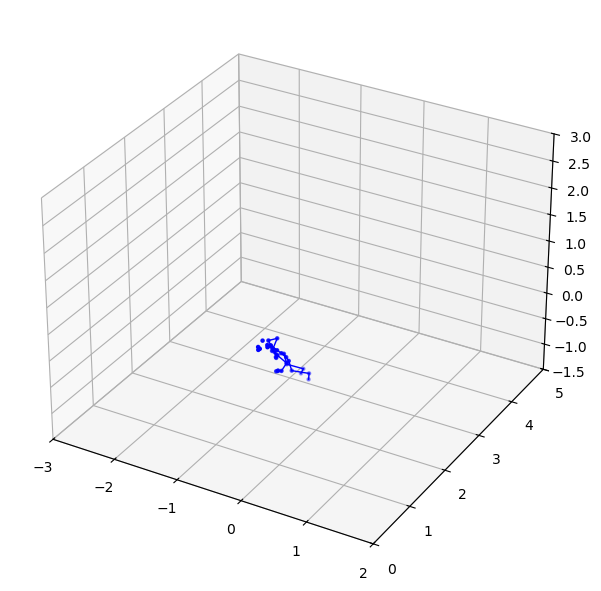

In [34]:
frame_idx = 5000
frame = data[frame_idx]
poses3d_raw = parse_poses3d(frame['poses3d'])

if poses3d_raw is not None and len(poses3d_raw) == 1:
    pose = poses3d_raw[0][None, ...]  # (1,32,4)
    empty_pc = np.zeros((0,6), dtype=float)  # ⚠️ cloud 需要6列
    from plot_utils import plot_pc_3d
    plot_pc_3d(empty_pc, pose)

else:
    print("No single-person pose detected.")


In [35]:
all_poses = []
for idx, frame in enumerate(data):
    poses3d_raw = parse_poses3d(frame['poses3d'])
    if poses3d_raw is not None and len(poses3d_raw) == 1:   # 单人
        all_poses.append(poses3d_raw[0])   # (32,4)
    else:
        all_poses.append(np.zeros((32,4))) # 没检测到人 → 补零

all_poses = np.stack(all_poses, axis=0)    # (T,32,4)
print("Final shape:", all_poses.shape)

Final shape: (47199, 32, 4)


In [36]:
# 去掉 conf 列
all_xyz = all_poses[..., :3]   # (T,32,3)

# 保存为 .npy
save_path = os.path.join("data", "poses_09SY.npy")
np.save(save_path, all_xyz)

print(f"已保存: {save_path}")

已保存: data\poses_09SY.npy


In [56]:
import os
import numpy as np

# ==== 可调参数（按你们19MM旧模型习惯）====
CENTER_JOINT = 0
TORSO_PAIRS = [(11, 12), (5, 6)]  # (L_hip,R_hip)、(L_shoulder,R_shoulder) 仅示例
EPS = 1e-6

def center_and_scale(x, center_joint=CENTER_JOINT, torso_pairs=TORSO_PAIRS, eps=EPS):
    """
    x: (T, J, 3)  — float, 可含全零帧
    处理：
      1) 以 center_joint 做平移居中（x,y,z全部减去该关节坐标）
      2) 按 torso_pairs 计算每帧“躯干长度”的平均值，做等比例缩放
    规则：
      - 全零帧保持全零
      - 躯干尺度=0时，不缩放（scale=1）
    """
    x = x.copy()
    T, J, C = x.shape
    assert C == 3, f"expected (T,J,3), got {x.shape}"
    
    # 标记全零帧（例如检测失败补零时）
    zero_mask = (x == 0).all(axis=(1,2))  # (T,)

    # 1) 居中
    center = x[:, center_joint:center_joint+1, :]  # (T,1,3)
    x = x - center

    # 2) 按躯干平均长度归一化
    #   计算每个 pair 的欧氏距离，再按pairs求平均
    scales = []
    for (a, b) in torso_pairs:
        d = np.linalg.norm(x[:, a, :] - x[:, b, :], axis=-1)  # (T,)
        scales.append(d)
    if len(scales) == 0:
        scale = np.ones((T,), dtype=x.dtype)
    else:
        scale = np.mean(np.stack(scales, axis=-1), axis=-1)  # (T,)
    scale = np.where(scale < eps, 1.0, scale)  # 防止除零
    scale = scale.reshape(T, 1, 1)

    x = x / scale

    # 让全零帧仍保持全零（避免被“居中/缩放”污染）
    x[zero_mask] = 0.0
    return x

def process_file(in_path, out_path):
    arr = np.load(in_path)  # (T,32,3)
    print(f"load: {in_path}, shape={arr.shape}")
    arr2 = center_and_scale(arr)
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    np.save(out_path, arr2)
    # 小检查
    zero_ratio = (arr2 == 0).all(axis=(1,2)).mean()
    print(f"saved: {out_path}, shape={arr2.shape}, zero_frames={zero_ratio*100:.2f}%")
    return arr2

# ==== 批处理 16GZ & 17JP ====
arr_16gz = process_file("data/poses_09SY.npy", "data/poses_09SY_cs.npy")


load: data/poses_09SY.npy, shape=(47199, 32, 3)
saved: data/poses_09SY_cs.npy, shape=(47199, 32, 3), zero_frames=50.55%


In [57]:
import os
import numpy as np

def drop_zero_frames(in_path, out_path, idx_out_path=None):
    """
    读取 (T,32,3) 的 npy，删除全零帧；保存过滤后的数组以及保留索引。
    """
    x = np.load(in_path)  # (T,32,3)
    T = len(x)
    zero = (x == 0).all(axis=(1,2))          # True=全零帧
    keep_idx = np.where(~zero)[0]            # 保留的帧索引
    x_f = x[keep_idx]
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    np.save(out_path, x_f)
    if idx_out_path:
        np.save(idx_out_path, keep_idx)
    print(f"[OK] {in_path} -> {out_path}")
    print(f"    shape: {x.shape} -> {x_f.shape}, removed {zero.sum()}/{T} ({zero.mean()*100:.2f}%)")
    if idx_out_path:
        print(f"    kept_indices -> {idx_out_path}")
    return keep_idx, x_f

# === 对 16GZ / 17JP / 19MM 分别执行（以 _cs 版本为输入） ===
k09, x09 = drop_zero_frames(
    "data/poses_09SY_cs.npy",
    "data/poses_09SY_cs_nz.npy",
    "data/poses_09SY_kept_idx.npy"
)



[OK] data/poses_09SY_cs.npy -> data/poses_09SY_cs_nz.npy
    shape: (47199, 32, 3) -> (23341, 32, 3), removed 23858/47199 (50.55%)
    kept_indices -> data/poses_09SY_kept_idx.npy


In [58]:
# ===== 只提取五个标签: walk / lie / sit / stand / bend =====
# 修改这两个路径即可：
PKL = "data/09_SY.pickle"                # ← 改成你的 pickle （16GZ / 17JP / 19MM）
OUT_NPY = "data/labels_09SY.npy"     # ← 输出逐帧标签

import os, pickle, numpy as np

FIVE = {"walk","lie","sit","stand","bend"}

ALIAS = {
    # walk
    "walk":"walk","walking":"walk","walks":"walk","a_walk":"walk",
    # lie
    "lie":"lie","lying":"lie","p_lie":"lie","a_lie":"lie",
    # sit
    "sit":"sit","sitting":"sit","p_sit":"sit","a_sit":"sit",
    # stand
    "stand":"stand","standing":"stand","p_stand":"stand","a_stand":"stand",
    # bend
    "bend":"bend","bending":"bend","t_bend":"bend","a_bend":"bend",
}

def _map5(x):
    if x is None: return None
    s = str(x).strip().lower()
    s = ALIAS.get(s, s)
    return s if s in FIVE else None

def _search_label(obj):
    """从任意结构中找到五类标签"""
    if obj is None: return None

    # string
    if isinstance(obj, str):
        return _map5(obj)

    # list
    if isinstance(obj, (list,tuple)):
        for item in obj:
            m = _search_label(item)
            if m: return m
        return None

    # dict：检查常见键
    if isinstance(obj, dict):
        for key in ("label","labels","raw_label","raw_labels",
                    "action","actions","tag","tags","activity","activities","name","text"):
            if key in obj:
                m = _search_label(obj[key])
                if m: return m
        # 全部值兜底
        for v in obj.values():
            m = _search_label(v)
            if m: return m
        return None

    return None


# ====== 开始读取 pickle ======
assert os.path.isfile(PKL), f"❌ 找不到 pickle: {PKL}"
print(f"[读取] {PKL}")

with open(PKL,"rb") as f:
    data = pickle.load(f)


# ====== 寻找逐帧列表 ======
frames = None
if isinstance(data, list):
    frames = data
elif isinstance(data, dict):
    for key in ("frames","data","samples"):
        if key in data and isinstance(data[key], list):
            frames = data[key]
            print(f"[info] 使用 frames 列表，key='{key}', 长度={len(frames)}")
            break

if frames is None:
    raise RuntimeError("❌ 没找到逐帧列表（frames/data/samples）。无法提取标签。发我一帧结构我帮你适配。")

T = len(frames)
labels = [None]*T

print(f"[info] 共 {T} 帧，开始提取标签...")

for i, fr in enumerate(frames):
    lab = _search_label(fr)
    labels[i] = lab
    if i % max(1, T//10) == 0:
        print(f"  {i}/{T} → {lab}")

labels = np.array(labels, dtype=object)

# 统计有效标签覆盖率
cov = (labels != None).mean() * 100
print(f"\n✅ 五类有效标签覆盖率：{cov:.2f}%")

# 保存
os.makedirs(os.path.dirname(OUT_NPY), exist_ok=True)
np.save(OUT_NPY, labels)

print(f"✅ 保存完成：{OUT_NPY}, shape={labels.shape}")

[读取] data/09_SY.pickle
[info] 共 47199 帧，开始提取标签...
  0/47199 → None
  4719/47199 → None
  9438/47199 → lie
  14157/47199 → None
  18876/47199 → None
  23595/47199 → None
  28314/47199 → None
  33033/47199 → sit
  37752/47199 → sit
  42471/47199 → None
  47190/47199 → None

✅ 五类有效标签覆盖率：43.42%
✅ 保存完成：data/labels_09SY.npy, shape=(47199,)


In [37]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from parsers import parse_poses3d

In [38]:
pickle_filename = "05_HW.pickle"   # 改成你的文件名
data_path = os.path.join("data", pickle_filename)

with open(data_path, "rb") as handle:
    data = pickle.load(handle)

print(f"总帧数: {len(data)}")
print("示例 keys:", data[0].keys())


总帧数: 31296
示例 keys: dict_keys(['poses3d', 'poses2d', 'activities', 'num_people', 'rgb_frame_number', 'pc', 'raw_fids', 'radar_session_datetime', 'wallclock', 'PoseNDF_score2d', 'PoseNDF_score3d'])


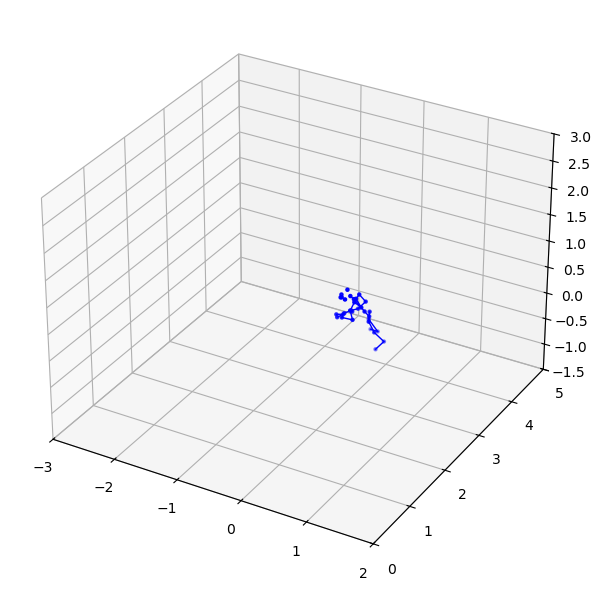

In [39]:
frame_idx = 5000
frame = data[frame_idx]
poses3d_raw = parse_poses3d(frame['poses3d'])

if poses3d_raw is not None and len(poses3d_raw) == 1:
    pose = poses3d_raw[0][None, ...]  # (1,32,4)
    empty_pc = np.zeros((0,6), dtype=float)  # ⚠️ cloud 需要6列
    from plot_utils import plot_pc_3d
    plot_pc_3d(empty_pc, pose)

else:
    print("No single-person pose detected.")


In [40]:
all_poses = []
for idx, frame in enumerate(data):
    poses3d_raw = parse_poses3d(frame['poses3d'])
    if poses3d_raw is not None and len(poses3d_raw) == 1:   # 单人
        all_poses.append(poses3d_raw[0])   # (32,4)
    else:
        all_poses.append(np.zeros((32,4))) # 没检测到人 → 补零

all_poses = np.stack(all_poses, axis=0)    # (T,32,4)
print("Final shape:", all_poses.shape)


Final shape: (31296, 32, 4)


In [41]:
# 去掉 conf 列
all_xyz = all_poses[..., :3]   # (T,32,3)

# 保存为 .npy
save_path = os.path.join("data", "poses_05HW.npy")
np.save(save_path, all_xyz)

print(f"已保存: {save_path}")

已保存: data\poses_05HW.npy


In [42]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from parsers import parse_poses3d

In [43]:
pickle_filename = "14_IB.pickle"   # 改成你的文件名
data_path = os.path.join("data", pickle_filename)

with open(data_path, "rb") as handle:
    data = pickle.load(handle)

print(f"总帧数: {len(data)}")
print("示例 keys:", data[0].keys())

总帧数: 37532
示例 keys: dict_keys(['poses3d', 'poses2d', 'activities', 'num_people', 'rgb_frame_number', 'pc', 'raw_fids', 'radar_session_datetime', 'wallclock', 'PoseNDF_score2d', 'PoseNDF_score3d'])


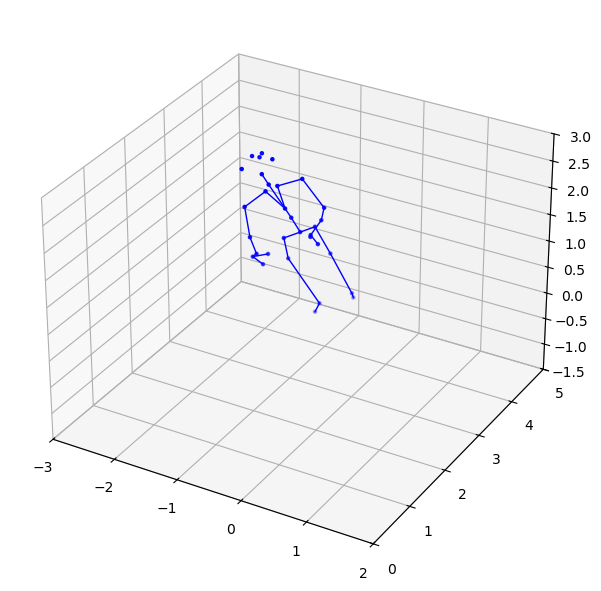

In [44]:
frame_idx = 1000
frame = data[frame_idx]
poses3d_raw = parse_poses3d(frame['poses3d'])

if poses3d_raw is not None and len(poses3d_raw) == 1:
    pose = poses3d_raw[0][None, ...]  # (1,32,4)
    empty_pc = np.zeros((0,6), dtype=float)  # ⚠️ cloud 需要6列
    from plot_utils import plot_pc_3d
    scale = 3.0
    pose_scaled = pose * scale
    plot_pc_3d(empty_pc, pose_scaled)


else:
    print("No single-person pose detected.")


In [45]:
all_poses = []
for idx, frame in enumerate(data):
    poses3d_raw = parse_poses3d(frame['poses3d'])
    if poses3d_raw is not None and len(poses3d_raw) == 1:   # 单人
        all_poses.append(poses3d_raw[0])   # (32,4)
    else:
        all_poses.append(np.zeros((32,4))) # 没检测到人 → 补零

all_poses = np.stack(all_poses, axis=0)    # (T,32,4)
print("Final shape:", all_poses.shape)

Final shape: (37532, 32, 4)


In [46]:
# 去掉 conf 列
all_xyz = all_poses[..., :3]   # (T,32,3)

# 保存为 .npy
save_path = os.path.join("data", "poses_14IB.npy")
np.save(save_path, all_xyz)

print(f"已保存: {save_path}")

已保存: data\poses_14IB.npy


In [73]:
import os
import numpy as np

# ==== 可调参数（按你们19MM旧模型习惯）====
CENTER_JOINT = 0
TORSO_PAIRS = [(11, 12), (5, 6)]  # (L_hip,R_hip)、(L_shoulder,R_shoulder) 仅示例
EPS = 1e-6

def center_and_scale(x, center_joint=CENTER_JOINT, torso_pairs=TORSO_PAIRS, eps=EPS):
    """
    x: (T, J, 3)  — float, 可含全零帧
    处理：
      1) 以 center_joint 做平移居中（x,y,z全部减去该关节坐标）
      2) 按 torso_pairs 计算每帧“躯干长度”的平均值，做等比例缩放
    规则：
      - 全零帧保持全零
      - 躯干尺度=0时，不缩放（scale=1）
    """
    x = x.copy()
    T, J, C = x.shape
    assert C == 3, f"expected (T,J,3), got {x.shape}"
    
    # 标记全零帧（例如检测失败补零时）
    zero_mask = (x == 0).all(axis=(1,2))  # (T,)

    # 1) 居中
    center = x[:, center_joint:center_joint+1, :]  # (T,1,3)
    x = x - center

    # 2) 按躯干平均长度归一化
    #   计算每个 pair 的欧氏距离，再按pairs求平均
    scales = []
    for (a, b) in torso_pairs:
        d = np.linalg.norm(x[:, a, :] - x[:, b, :], axis=-1)  # (T,)
        scales.append(d)
    if len(scales) == 0:
        scale = np.ones((T,), dtype=x.dtype)
    else:
        scale = np.mean(np.stack(scales, axis=-1), axis=-1)  # (T,)
    scale = np.where(scale < eps, 1.0, scale)  # 防止除零
    scale = scale.reshape(T, 1, 1)

    x = x / scale

    # 让全零帧仍保持全零（避免被“居中/缩放”污染）
    x[zero_mask] = 0.0
    return x

def process_file(in_path, out_path):
    arr = np.load(in_path)  # (T,32,3)
    print(f"load: {in_path}, shape={arr.shape}")
    arr2 = center_and_scale(arr)
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    np.save(out_path, arr2)
    # 小检查
    zero_ratio = (arr2 == 0).all(axis=(1,2)).mean()
    print(f"saved: {out_path}, shape={arr2.shape}, zero_frames={zero_ratio*100:.2f}%")
    return arr2

# ==== 批处理 16GZ & 17JP ====
arr_05hw = process_file("data/poses_05HW.npy", "data/poses_05HW_cs.npy")
arr_14ib = process_file("data/poses_14IB.npy", "data/poses_14IB_cs.npy")

load: data/poses_05HW.npy, shape=(31296, 32, 3)
saved: data/poses_05HW_cs.npy, shape=(31296, 32, 3), zero_frames=39.70%
load: data/poses_14IB.npy, shape=(37532, 32, 3)
saved: data/poses_14IB_cs.npy, shape=(37532, 32, 3), zero_frames=48.37%


In [74]:
import os
import numpy as np

def drop_zero_frames(in_path, out_path, idx_out_path=None):
    """
    读取 (T,32,3) 的 npy，删除全零帧；保存过滤后的数组以及保留索引。
    """
    x = np.load(in_path)  # (T,32,3)
    T = len(x)
    zero = (x == 0).all(axis=(1,2))          # True=全零帧
    keep_idx = np.where(~zero)[0]            # 保留的帧索引
    x_f = x[keep_idx]
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    np.save(out_path, x_f)
    if idx_out_path:
        np.save(idx_out_path, keep_idx)
    print(f"[OK] {in_path} -> {out_path}")
    print(f"    shape: {x.shape} -> {x_f.shape}, removed {zero.sum()}/{T} ({zero.mean()*100:.2f}%)")
    if idx_out_path:
        print(f"    kept_indices -> {idx_out_path}")
    return keep_idx, x_f

# === 对 16GZ / 17JP / 19MM 分别执行（以 _cs 版本为输入） ===
k05, x05 = drop_zero_frames(
    "data/poses_05HW_cs.npy",
    "data/poses_05HW_cs_nz.npy",
    "data/poses_05HW_kept_idx.npy"
)

k14, x14 = drop_zero_frames(
    "data/poses_14IB_cs.npy",
    "data/poses_14IB_cs_nz.npy",
    "data/poses_14IB_kept_idx.npy"
)



[OK] data/poses_05HW_cs.npy -> data/poses_05HW_cs_nz.npy
    shape: (31296, 32, 3) -> (18871, 32, 3), removed 12425/31296 (39.70%)
    kept_indices -> data/poses_05HW_kept_idx.npy
[OK] data/poses_14IB_cs.npy -> data/poses_14IB_cs_nz.npy
    shape: (37532, 32, 3) -> (19377, 32, 3), removed 18155/37532 (48.37%)
    kept_indices -> data/poses_14IB_kept_idx.npy


In [75]:
# ===== 只提取五个标签: walk / lie / sit / stand / bend =====
# 修改这两个路径即可：
PKL = "data/05_HW.pickle"                # ← 改成你的 pickle （16GZ / 17JP / 19MM）
OUT_NPY = "data/labels_05HW.npy"     # ← 输出逐帧标签

import os, pickle, numpy as np

FIVE = {"walk","lie","sit","stand","bend"}

ALIAS = {
    # walk
    "walk":"walk","walking":"walk","walks":"walk","a_walk":"walk",
    # lie
    "lie":"lie","lying":"lie","p_lie":"lie","a_lie":"lie",
    # sit
    "sit":"sit","sitting":"sit","p_sit":"sit","a_sit":"sit",
    # stand
    "stand":"stand","standing":"stand","p_stand":"stand","a_stand":"stand",
    # bend
    "bend":"bend","bending":"bend","t_bend":"bend","a_bend":"bend",
}

def _map5(x):
    if x is None: return None
    s = str(x).strip().lower()
    s = ALIAS.get(s, s)
    return s if s in FIVE else None

def _search_label(obj):
    """从任意结构中找到五类标签"""
    if obj is None: return None

    # string
    if isinstance(obj, str):
        return _map5(obj)

    # list
    if isinstance(obj, (list,tuple)):
        for item in obj:
            m = _search_label(item)
            if m: return m
        return None

    # dict：检查常见键
    if isinstance(obj, dict):
        for key in ("label","labels","raw_label","raw_labels",
                    "action","actions","tag","tags","activity","activities","name","text"):
            if key in obj:
                m = _search_label(obj[key])
                if m: return m
        # 全部值兜底
        for v in obj.values():
            m = _search_label(v)
            if m: return m
        return None

    return None


# ====== 开始读取 pickle ======
assert os.path.isfile(PKL), f"❌ 找不到 pickle: {PKL}"
print(f"[读取] {PKL}")

with open(PKL,"rb") as f:
    data = pickle.load(f)


# ====== 寻找逐帧列表 ======
frames = None
if isinstance(data, list):
    frames = data
elif isinstance(data, dict):
    for key in ("frames","data","samples"):
        if key in data and isinstance(data[key], list):
            frames = data[key]
            print(f"[info] 使用 frames 列表，key='{key}', 长度={len(frames)}")
            break

if frames is None:
    raise RuntimeError("❌ 没找到逐帧列表（frames/data/samples）。无法提取标签。发我一帧结构我帮你适配。")

T = len(frames)
labels = [None]*T

print(f"[info] 共 {T} 帧，开始提取标签...")

for i, fr in enumerate(frames):
    lab = _search_label(fr)
    labels[i] = lab
    if i % max(1, T//10) == 0:
        print(f"  {i}/{T} → {lab}")

labels = np.array(labels, dtype=object)

# 统计有效标签覆盖率
cov = (labels != None).mean() * 100
print(f"\n✅ 五类有效标签覆盖率：{cov:.2f}%")

# 保存
os.makedirs(os.path.dirname(OUT_NPY), exist_ok=True)
np.save(OUT_NPY, labels)

print(f"✅ 保存完成：{OUT_NPY}, shape={labels.shape}")

[读取] data/05_HW.pickle
[info] 共 31296 帧，开始提取标签...
  0/31296 → None
  3129/31296 → None
  6258/31296 → None
  9387/31296 → None
  12516/31296 → lie
  15645/31296 → None
  18774/31296 → None
  21903/31296 → sit
  25032/31296 → sit
  28161/31296 → sit
  31290/31296 → None

✅ 五类有效标签覆盖率：31.81%
✅ 保存完成：data/labels_05HW.npy, shape=(31296,)


In [76]:
# ===== 只提取五个标签: walk / lie / sit / stand / bend =====
# 修改这两个路径即可：
PKL = "data/14_IB.pickle"                # ← 改成你的 pickle （16GZ / 17JP / 19MM）
OUT_NPY = "data/labels_14IB.npy"     # ← 输出逐帧标签

import os, pickle, numpy as np

FIVE = {"walk","lie","sit","stand","bend"}

ALIAS = {
    # walk
    "walk":"walk","walking":"walk","walks":"walk","a_walk":"walk",
    # lie
    "lie":"lie","lying":"lie","p_lie":"lie","a_lie":"lie",
    # sit
    "sit":"sit","sitting":"sit","p_sit":"sit","a_sit":"sit",
    # stand
    "stand":"stand","standing":"stand","p_stand":"stand","a_stand":"stand",
    # bend
    "bend":"bend","bending":"bend","t_bend":"bend","a_bend":"bend",
}

def _map5(x):
    if x is None: return None
    s = str(x).strip().lower()
    s = ALIAS.get(s, s)
    return s if s in FIVE else None

def _search_label(obj):
    """从任意结构中找到五类标签"""
    if obj is None: return None

    # string
    if isinstance(obj, str):
        return _map5(obj)

    # list
    if isinstance(obj, (list,tuple)):
        for item in obj:
            m = _search_label(item)
            if m: return m
        return None

    # dict：检查常见键
    if isinstance(obj, dict):
        for key in ("label","labels","raw_label","raw_labels",
                    "action","actions","tag","tags","activity","activities","name","text"):
            if key in obj:
                m = _search_label(obj[key])
                if m: return m
        # 全部值兜底
        for v in obj.values():
            m = _search_label(v)
            if m: return m
        return None

    return None


# ====== 开始读取 pickle ======
assert os.path.isfile(PKL), f"❌ 找不到 pickle: {PKL}"
print(f"[读取] {PKL}")

with open(PKL,"rb") as f:
    data = pickle.load(f)


# ====== 寻找逐帧列表 ======
frames = None
if isinstance(data, list):
    frames = data
elif isinstance(data, dict):
    for key in ("frames","data","samples"):
        if key in data and isinstance(data[key], list):
            frames = data[key]
            print(f"[info] 使用 frames 列表，key='{key}', 长度={len(frames)}")
            break

if frames is None:
    raise RuntimeError("❌ 没找到逐帧列表（frames/data/samples）。无法提取标签。发我一帧结构我帮你适配。")

T = len(frames)
labels = [None]*T

print(f"[info] 共 {T} 帧，开始提取标签...")

for i, fr in enumerate(frames):
    lab = _search_label(fr)
    labels[i] = lab
    if i % max(1, T//10) == 0:
        print(f"  {i}/{T} → {lab}")

labels = np.array(labels, dtype=object)

# 统计有效标签覆盖率
cov = (labels != None).mean() * 100
print(f"\n✅ 五类有效标签覆盖率：{cov:.2f}%")

# 保存
os.makedirs(os.path.dirname(OUT_NPY), exist_ok=True)
np.save(OUT_NPY, labels)

print(f"✅ 保存完成：{OUT_NPY}, shape={labels.shape}")

[读取] data/14_IB.pickle
[info] 共 37532 帧，开始提取标签...
  0/37532 → None
  3753/37532 → stand
  7506/37532 → None
  11259/37532 → stand
  15012/37532 → None
  18765/37532 → walk
  22518/37532 → sit
  26271/37532 → sit
  30024/37532 → sit
  33777/37532 → sit
  37530/37532 → stand

✅ 五类有效标签覆盖率：77.29%
✅ 保存完成：data/labels_14IB.npy, shape=(37532,)


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from parsers import parse_poses3d

# 从 frame 里拿到「单人」3D pose，返回 (J, 3) 或 None
def get_single_pose_xyz(frame):
    poses3d_raw = parse_poses3d(frame['poses3d'])
    if poses3d_raw is None or len(poses3d_raw) != 1:
        return None
    pose = poses3d_raw[0][..., :3]   # (J,4) -> (J,3) 只要 xyz
    return pose

# 选择一段连续帧：起始帧、步长、帧数
start_idx = 1000   # 你可以改成别的起点
step      = 2      # 每隔多少帧取一个
num_frames = 12    # 一共想画多少个小人

poses_seq = []
frame_ids = []

for i in range(num_frames):
    idx = start_idx + i * step
    frame = data[idx]
    pose = get_single_pose_xyz(frame)
    if pose is not None:
        poses_seq.append(pose)
        frame_ids.append(idx)

poses_seq = np.array(poses_seq)  # (K, J, 3)
print("有效帧数:", len(poses_seq))


有效帧数: 12


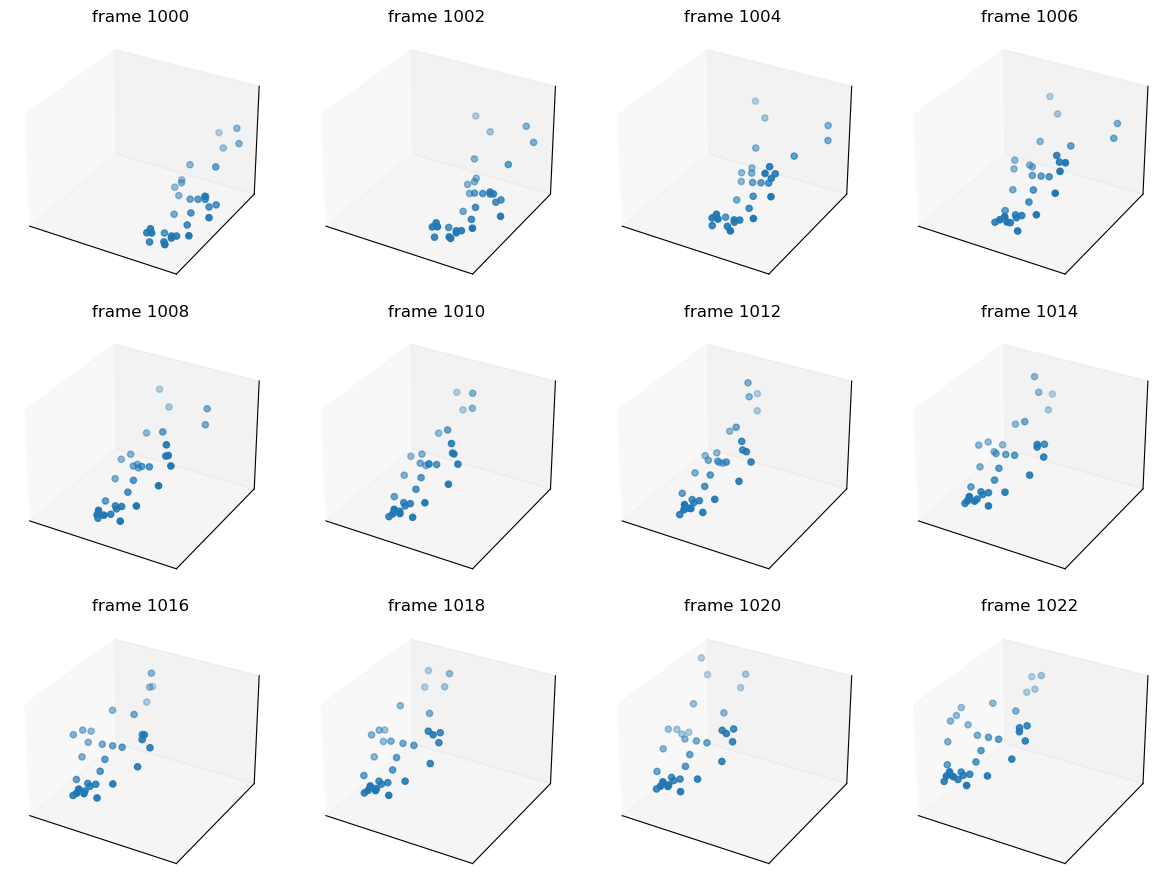

In [14]:
# 如果没有有效帧就直接返回
if len(poses_seq) == 0:
    print("没有找到单人 pose 的帧，换一个 start_idx 试试～")
else:
    K = len(poses_seq)
    cols = 4                           # 每行几个小人
    rows = int(np.ceil(K / cols))

    fig = plt.figure(figsize=(cols * 3, rows * 3))

    # 为了所有子图的比例一致，先算一个全局坐标范围
    xs = poses_seq[..., 0].ravel()
    ys = poses_seq[..., 1].ravel()
    zs = poses_seq[..., 2].ravel()
    x_min, x_max = xs.min() - 0.2, xs.max() + 0.2
    y_min, y_max = ys.min() - 0.2, ys.max() + 0.2
    z_min, z_max = zs.min() - 0.2, zs.max() + 0.2

    for i, pose in enumerate(poses_seq):
        ax = fig.add_subplot(rows, cols, i + 1, projection='3d')

        # 只画关键点：一个小蓝人
        ax.scatter(pose[:, 0], pose[:, 1], pose[:, 2], s=20)

        # 👉 如果你想把骨架连线，也可以用自己 constants.py 里的关节连接：
        # from constants import EDGES_32   # 举例
        # for a, b in EDGES_32:
        #     ax.plot([pose[a, 0], pose[b, 0]],
        #             [pose[a, 1], pose[b, 1]],
        #             [pose[a, 2], pose[b, 2]], linewidth=2)

        ax.set_title(f'frame {frame_ids[i]}')
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_zlim(z_min, z_max)
        ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])

    plt.tight_layout()
    plt.show()


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # 仅为兼容老版本
from constants import KINECT_LIMB_CONNECTIONS  # 或者你自己的 limb 列表名称

# 小工具：在指定 ax 上画一帧 3D skeleton
def draw_skeleton_3d(ax, pose, limbs=KINECT_LIMB_CONNECTIONS,
                     point_size=25, lw=2, c='C0'):
    """
    pose: (V, 3) 的单帧 3D 关节坐标
    limbs: [(i, j), ...] 关节连线
    """
    x = pose[:, 0]
    y = pose[:, 1]
    z = pose[:, 2]

    # 点
    ax.scatter(x, y, z, s=point_size, c=c)

    # 线（骨架）
    for i, j in limbs:
        ax.plot([x[i], x[j]],
                [y[i], y[j]],
                [z[i], z[j]],
                c=c, linewidth=lw)

    # 统一一下视角和轴范围（可以根据你数据适当调）
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.set_zlim(-1, 3)
    ax.view_init(elev=20, azim=-60)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])

# ==== 这里开始画 sequence，每个子图是一帧 ====
# poses_seq: (T, V, 3)
T = poses_seq.shape[0]

start = 1008       # 起始帧索引（随便挑一段）
step = 2           # 每隔几帧取一张
n_cols = 4         # 每行几个
n_rows = 3         # 几行
n_frames = n_cols * n_rows

frame_indices = start + np.arange(n_frames) * step
frame_indices = frame_indices[frame_indices < T]  # 不要越界

fig = plt.figure(figsize=(12, 9))

for k, idx in enumerate(frame_indices):
    ax = fig.add_subplot(n_rows, n_cols, k + 1, projection='3d')
    draw_skeleton_3d(ax, poses_seq[idx])
    ax.set_title(f'frame {idx}', fontsize=8)

plt.tight_layout()
plt.show()


<Figure size 1200x900 with 0 Axes>

In [17]:
# ==== Cell 1: imports & basic config ====
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

from parsers import parse_poses3d
from constants import KINECT_LIMB_CONNECTIONS  # 骨架边列表，形如 [(i, j), ...]

plt.rcParams['figure.figsize'] = (6, 6)
plt.rcParams['axes.grid'] = True


In [18]:
# ==== Cell 2: load pickle ====
DATA_DIR = "data"
pickle_filename = "14_IB.pickle"  # ← 在这里换成你想看的那个 session
data_path = os.path.join(DATA_DIR, pickle_filename)

with open(data_path, "rb") as f:
    data = pickle.load(f)

print(f"总帧数: {len(data)}")
print("示例 keys:", data[0].keys())


总帧数: 37532
示例 keys: dict_keys(['poses3d', 'poses2d', 'activities', 'num_people', 'rgb_frame_number', 'pc', 'raw_fids', 'radar_session_datetime', 'wallclock', 'PoseNDF_score2d', 'PoseNDF_score3d'])


In [19]:
# ==== Cell 3: helpers: get_single_pose & plotting functions ====

def get_single_pose_xyz(frame):
    """
    输入：pickle 中的一帧字典
    输出：若该帧恰好只有 1 个人体，则返回 (32,3) 的 xyz；否则返回 None
    """
    poses3d_raw = parse_poses3d(frame['poses3d'])
    if poses3d_raw is not None and len(poses3d_raw) == 1:
        pose = poses3d_raw[0]  # (32,4) -> x,y,z,conf
        xyz = pose[:, :3]      # 只取前三列
        return xyz
    else:
        return None


def set_equal_3d(ax, xyz, margin=0.2):
    """让三个轴等比例，并基于当前 pose 自动设置范围"""
    x, y, z = xyz[:, 0], xyz[:, 1], xyz[:, 2]
    x_min, x_max = x.min(), x.max()
    y_min, y_max = y.min(), y.max()
    z_min, z_max = z.min(), z.max()

    cx = 0.5 * (x_min + x_max)
    cy = 0.5 * (y_min + y_max)
    cz = 0.5 * (z_min + z_max)

    max_range = max(x_max - x_min, y_max - y_min, z_max - z_min) + margin

    ax.set_xlim(cx - max_range/2, cx + max_range/2)
    ax.set_ylim(cy - max_range/2, cy + max_range/2)
    ax.set_zlim(cz - max_range/2, cz + max_range/2)


def draw_pose_3d(ax, xyz, point_size=40, line_width=2, color='b'):
    """
    在给定的 3D Axes 上画一帧 skeleton:
      xyz: (32,3)
    """
    x, y, z = xyz[:, 0], xyz[:, 1], xyz[:, 2]

    # 关节点（稍微大一点）
    ax.scatter(x, y, z, c=color, s=point_size, depthshade=True)

    # 骨架连线（按 Kinect 拓扑）
    for i, j in KINECT_LIMB_CONNECTIONS:
        ax.plot(
            [x[i], x[j]],
            [y[i], y[j]],
            [z[i], z[j]],
            color=color,
            linewidth=line_width
        )

    set_equal_3d(ax, xyz)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")


In [21]:
# ==== Cell 5: build a pose sequence (多帧) ====

def build_pose_sequence(data, start, step=1, num_frames=12):
    """
    从给定起点开始，每隔 step 取一帧，取 num_frames 帧，
    只保留恰好单人的帧。
    返回：
        poses_seq: (T, 32, 3)
        frame_indices: 长度为 T 的 list
    """
    poses_list = []
    idx_list = []

    for k in range(num_frames):
        idx = start + k * step
        if idx < 0 or idx >= len(data):
            continue
        frame = data[idx]
        xyz = get_single_pose_xyz(frame)
        if xyz is not None:
            poses_list.append(xyz)
            idx_list.append(idx)

    if not poses_list:
        print("这个起点/步长组合没找到单人帧，请换一个 start 或 step。")
        return None, None

    poses_seq = np.stack(poses_list, axis=0)  # (T, 32, 3)
    return poses_seq, idx_list


# 示例：从某个帧附近取 12 帧
start = 1008   # 可以根据你前面单帧可视化结果来调整
step = 2
num = 12

poses3d_seq, frame_indices = build_pose_sequence(data, start, step=step, num_frames=num)
print("sequence shape:", None if poses3d_seq is None else poses3d_seq.shape)
print("frame indices:", frame_indices)


sequence shape: (12, 32, 3)
frame indices: [1008, 1010, 1012, 1014, 1016, 1018, 1020, 1022, 1024, 1026, 1028, 1030]


In [2]:
import os
import numpy as np

DATA_DIR = "data"
DATASETS = ["16GZ", "17JP", "19MM", "09SY", "05HW", "14IB"]

all_labels = []

for name in DATASETS:
    label_path = os.path.join(DATA_DIR, f"labels_{name}.npy")

    if not os.path.exists(label_path):
        print(f"{name}: ❌ label file not found")
        continue
    
    y = np.load(label_path, allow_pickle=True)
    print(f"{name}: {len(y)} samples")
    
    all_labels.extend(list(y))

# ------- 过滤 None -------
unique_labels = sorted({lb for lb in all_labels if lb is not None})

print("\n===== ALL PHYSICAL STATE LABELS =====")
for lb in unique_labels:
    print(lb)


16GZ: 33409 samples
17JP: 36546 samples
19MM: 34001 samples
09SY: 47199 samples
05HW: 31296 samples
14IB: 37532 samples

===== ALL PHYSICAL STATE LABELS =====
bend
lie
sit
stand
walk


In [3]:
import os
import pickle

DATA_DIR = "data"
PICKLES = ["14_IB.pickle", "05_HW.pickle", "09_SY.pickle", "16_GZ.pickle", "17_JP.pickle", "19_MM.pickle"]

all_states = set()

for fname in PICKLES:
    path = os.path.join(DATA_DIR, fname)
    print(f"Reading {fname} ...")

    with open(path, "rb") as f:
        data = pickle.load(f)

    for frame in data:
        acts = frame.get("activities", None)

        if acts is None:
            continue
        if isinstance(acts, str):
            all_states.add(acts)
        elif isinstance(acts, list):
            for a in acts:
                if a is not None:
                    all_states.add(a)

print("\n===== ALL RAW PHYSICAL STATE LABELS (from original pickle) =====")
for s in sorted(all_states):
    print(s)


Reading 14_IB.pickle ...
Reading 05_HW.pickle ...
Reading 09_SY.pickle ...
Reading 16_GZ.pickle ...
Reading 17_JP.pickle ...
Reading 19_MM.pickle ...

===== ALL RAW PHYSICAL STATE LABELS (from original pickle) =====


In [5]:
import os
import pickle
from collections import Counter

DATA_DIR = "data"
DATASETS = ["14_IB", "05_HW", "09_SY", "16_GZ", "17_JP", "19_MM"]

def safe_load_pickle(path):
    """安全加载 pickle，兼容 bytes / latin1"""
    with open(path, "rb") as f:
        return pickle.load(f)

def extract_labels_from_frame(frame):
    """从单帧中提取 physical state，自动适配各种格式"""
    labels = []

    # 1) activities 列表
    acts = frame.get("activities", [])
    for a in acts:
        if not isinstance(a, dict):
            continue  # 跳过字符串
        lb = (a.get("physical_state") or 
              a.get("physicalState") or 
              a.get("pose_label") or 
              a.get("label"))
        if lb is not None:
            labels.append(lb)

    # 2) frame 级字段（有些 pickle 直接存在）
    for key in ["physical_state", "physicalState", "pose_label", "label"]:
        if key in frame and isinstance(frame[key], str):
            labels.append(frame[key])

    return labels


def collect_physical_state(path):
    """遍历所有帧，提取物理状态标签"""
    data = safe_load_pickle(path)
    all_labels = []
    for frame in data:
        lbs = extract_labels_from_frame(frame)
        all_labels.extend(lbs)
    return all_labels


# =========================================================
#                   RUN FOR ALL DATASETS
# =========================================================

print("===== READING RAW PHYSICAL STATE LABELS =====\n")

global_labels = []

for name in DATASETS:
    pkl_path = os.path.join(DATA_DIR, f"{name}.pickle")
    print(f"Reading {pkl_path} ...")

    labels = collect_physical_state(pkl_path)
    cnt = Counter(labels)

    print(f"→ {name}: {len(labels)} labels, unique={len(cnt)}")
    for lb, c in cnt.items():
        print(f"    {lb}: {c}")

    global_labels.extend(labels)

# —— 输出所有数据集中出现过的物理状态 label ——
print("\n===== ALL RAW PHYSICAL STATE LABELS (FROM ORIGINAL PICKLE) =====")
for lb in sorted(set(global_labels)):
    print(lb)


===== READING RAW PHYSICAL STATE LABELS =====

Reading data\14_IB.pickle ...
→ 14_IB: 0 labels, unique=0
Reading data\05_HW.pickle ...
→ 05_HW: 0 labels, unique=0
Reading data\09_SY.pickle ...
→ 09_SY: 0 labels, unique=0
Reading data\16_GZ.pickle ...
→ 16_GZ: 0 labels, unique=0
Reading data\17_JP.pickle ...
→ 17_JP: 0 labels, unique=0
Reading data\19_MM.pickle ...
→ 19_MM: 0 labels, unique=0

===== ALL RAW PHYSICAL STATE LABELS (FROM ORIGINAL PICKLE) =====


In [13]:
import os
import numpy as np

DATASETS = ["16GZ", "17JP", "19MM", "09SY", "05HW", "14IB"]
DATA_DIR = "data"

all_raw_labels = []

for name in DATASETS:
    path = os.path.join(DATA_DIR, f"labels_{name}.npy")
    y = np.load(path, allow_pickle=True)
    print(f"{name}: {len(y)} samples")

    uniq = sorted(set([v for v in y if v is not None]))
    print(f"  unique labels: {uniq}")

    all_raw_labels.extend([v for v in y if v is not None])

print("\n==== Global unique labels ====")
print(sorted(set(all_raw_labels)))


16GZ: 33409 samples
  unique labels: ['bend', 'lie', 'sit', 'stand', 'walk']
17JP: 36546 samples
  unique labels: ['bend', 'lie', 'sit', 'stand', 'walk']
19MM: 34001 samples
  unique labels: ['bend', 'lie', 'sit', 'stand', 'walk']
09SY: 47199 samples
  unique labels: ['bend', 'lie', 'sit', 'stand', 'walk']
05HW: 31296 samples
  unique labels: ['bend', 'lie', 'sit', 'stand', 'walk']
14IB: 37532 samples
  unique labels: ['bend', 'lie', 'sit', 'stand', 'walk']

==== Global unique labels ====
['bend', 'lie', 'sit', 'stand', 'walk']


In [15]:
import pickle, os

PKL = "data/16_GZ.pickle"  # 换成你当前看的那个
with open(PKL, "rb") as f:
    data = pickle.load(f)

# 找到 frames 列表
if isinstance(data, list):
    frames = data
elif isinstance(data, dict):
    for k in ("frames", "data", "samples"):
        if k in data and isinstance(data[k], list):
            frames = data[k]
            break
else:
    frames = []

print("总帧数:", len(frames))

def get_phys_list(frame):
    acts = frame.get("activities", {})
    out = []
    for key, v in acts.items():
        if "PhysicalState" in key:
            # v 可能是 list / dict / str，这里先当 list 看看长度
            if isinstance(v, list):
                out.extend(v)
            else:
                out.append(v)
    return out

non_empty = 0
examples = []

for i, fr in enumerate(frames):
    phys = get_phys_list(fr)
    if phys:
        non_empty += 1
        if len(examples) < 5:
            examples.append((i, phys))

print("有 PhysicalState 的帧数:", non_empty)
for i, phys in examples:
    print(f"帧 {i}: {phys}")


总帧数: 33409
有 PhysicalState 的帧数: 27914
帧 4: ['p_sit', 'chair']
帧 5: ['p_sit', 'chair']
帧 6: ['p_sit', 'chair']
帧 7: ['p_sit', 'chair']
帧 8: ['p_sit', 'chair']


In [17]:
import os
import pickle
from collections import Counter

DATA_DIR = "data"   # 你的 pickle 所在目录
PKL_FILES = [
    "16_GZ.pickle",
    "17_JP.pickle",
    "19_MM.pickle",
    "09_SY.pickle",
    "05_HW.pickle",
    "14_IB.pickle",
]

def load_frames(pkl_path):
    """根据我们之前使用的格式，拿到逐帧列表"""
    with open(pkl_path, "rb") as f:
        data = pickle.load(f)

    # 大部分文件就是 list[frame]
    if isinstance(data, list):
        return data

    # 有些是 dict 包含 'frames' / 'data' / 'samples'
    if isinstance(data, dict):
        for key in ("frames", "data", "samples"):
            if key in data and isinstance(data[key], list):
                return data[key]

    raise RuntimeError(f" 无法在 {pkl_path} 里找到逐帧列表")

def get_physical_states_from_frame(frame):
    """
    从单帧里提取所有 PhysicalState 相关的原始字符串
    不做任何 p_ 过滤，只返回原始 label。
    """
    out = []

    acts = frame.get("activities", {})
    if not isinstance(acts, dict):
        return out

    # 所有 key 里包含 'PhysicalState' 的都算
    for key, value in acts.items():
        if "PhysicalState" not in key:
            continue

        # value 可能是 str / list[str] / list[dict] 等
        if isinstance(value, str):
            out.append(value)

        elif isinstance(value, (list, tuple)):
            for item in value:
                if isinstance(item, str):
                    out.append(item)
                elif isinstance(item, dict):
                    # 有些可能是 {'label': 'p_sit'} 之类
                    if "label" in item:
                        out.append(str(item["label"]))
                    else:
                        # 兜底把整个 dict 转成字符串看一眼
                        out.append(str(item))
                else:
                    out.append(str(item))

        elif isinstance(value, dict):
            # 少见情况，直接 dict 里有 'label'
            if "label" in value:
                out.append(str(value["label"]))
            else:
                out.append(str(value))

        else:
            out.append(str(value))

    return out


# ===== 统计所有文件中的 PhysicalState 原始类别 =====
global_counter = Counter()

for fname in PKL_FILES:
    pkl_path = os.path.join(DATA_DIR, fname)
    if not os.path.isfile(pkl_path):
        print(f" 找不到 {pkl_path}，跳过")
        continue

    print(f"\n 读取 {pkl_path} ...", flush=True)
    frames = load_frames(pkl_path)
    print(f"  总帧数: {len(frames)}")

    local_cnt = Counter()
    for fr in frames:
        labels = get_physical_states_from_frame(fr)
        local_cnt.update(labels)
        global_counter.update(labels)

    print(f"  该文件中的 PhysicalState 类别数: {len(local_cnt)}")
    for lb, n in local_cnt.most_common(10):
        print(f"    {lb:20s} : {n}")
    if len(local_cnt) > 10:
        print(f"    ... 共 {len(local_cnt)} 类")

# ===== 汇总所有文件 =====
print("\n===== 所有文件汇总的 RAW PhysicalState 类别统计 =====")
print(f"总共不同类别数: {len(global_counter)}\n")

for lb, n in global_counter.most_common():
    print(f"{lb:20s} : {n}")



📂 读取 data\16_GZ.pickle ...
  总帧数: 33409
  该文件中的 PhysicalState 类别数: 19
    p_sit                : 13984
    p_stand              : 12800
    sofa                 : 7189
    a_walk               : 4821
    kitchen_table        : 3563
    p_bent               : 1885
    stool                : 1248
    p_situp              : 775
    p_lie                : 634
    bed                  : 632
    ... 共 19 类

📂 读取 data\17_JP.pickle ...
  总帧数: 36546
  该文件中的 PhysicalState 类别数: 16
    p_sit                : 13807
    p_stand              : 4930
    a_walk               : 4263
    p_bent               : 1976
    p_lie                : 815
    kitchen_table        : 684
    t_bed_turn           : 611
    t_straighten         : 553
    t_bend               : 537
    t_stand_to_sit       : 496
    ... 共 16 类

📂 读取 data\19_MM.pickle ...
  总帧数: 34001
  该文件中的 PhysicalState 类别数: 18
    p_sit                : 19728
    p_stand              : 11589
    a_walk               : 5419
    p_bent               

In [4]:
import pickle

with open("data/16_GZ.pickle","rb") as f:
    data = pickle.load(f)

frame = data[100]     # 随便取一帧
print(type(frame))
print(frame.keys())   # 看看里面有哪些字段

# 重点：找出 3D pose
for k in frame.keys():
    print("\n----", k, "----")
    print(type(frame[k]))
    print(frame[k])


<class 'dict'>
dict_keys(['poses3d', 'poses2d', 'activities', 'num_people', 'rgb_frame_number', 'pc', 'raw_fids', 'radar_session_datetime', 'wallclock', 'PoseNDF_score2d', 'PoseNDF_score3d'])

---- poses3d ----
<class 'numpy.ndarray'>
[-1.38518692e+02 -4.32405151e+02  3.12346045e+03  2.00000000e+00
 -1.63611359e+02 -5.99204834e+02  3.11924976e+03  2.00000000e+00
 -1.60622192e+02 -7.32071655e+02  3.09616357e+03  2.00000000e+00
 -1.50994949e+02 -9.25414124e+02  3.02770728e+03  2.00000000e+00
 -1.30666031e+02 -9.00491455e+02  3.06109155e+03  2.00000000e+00
 -2.24960747e+01 -8.89960510e+02  3.14150977e+03  2.00000000e+00
  2.08109009e+02 -7.87570679e+02  3.20965234e+03  2.00000000e+00
  3.71444611e+02 -7.00758667e+02  3.09174390e+03  2.00000000e+00
  4.47903168e+02 -6.74536926e+02  3.04978857e+03  0.00000000e+00
  5.23584106e+02 -6.21342468e+02  3.00635742e+03  0.00000000e+00
  4.46828613e+02 -6.64564209e+02  3.01062939e+03  0.00000000e+00
 -1.75828033e+02 -8.86997681e+02  3.01832275e+03  

In [7]:
import pickle

with open("data/16_GZ.pickle", "rb") as f:
    data = pickle.load(f)

print("TOP-LEVEL TYPE:", type(data))
print("TOP-LEVEL LENGTH:", len(data))  # 如果是 list

# 打印前两个元素的类型
print("Element[0] type:", type(data[0]))
print("Element[1] keys:", data[1].keys())


TOP-LEVEL TYPE: <class 'list'>
TOP-LEVEL LENGTH: 33409
Element[0] type: <class 'dict'>
Element[1] keys: dict_keys(['poses3d', 'poses2d', 'activities', 'num_people', 'rgb_frame_number', 'pc', 'raw_fids', 'radar_session_datetime', 'wallclock', 'PoseNDF_score2d', 'PoseNDF_score3d'])


In [8]:
import pickle
import numpy as np

with open("data/16_GZ.pickle", "rb") as f:
    data = pickle.load(f)

print("TOP:", type(data), "len =", len(data))

first = data[0]
print("Frame keys:", first.keys())

arr = first["poses3d"]
print("\n--- poses3d info ---")
print("type:", type(arr))
print("shape:", getattr(arr, "shape", "no shape"))
print("len:", len(arr))
print(arr[:20])


TOP: <class 'list'> len = 33409
Frame keys: dict_keys(['poses3d', 'poses2d', 'activities', 'num_people', 'rgb_frame_number', 'pc', 'raw_fids', 'radar_session_datetime', 'wallclock', 'PoseNDF_score2d', 'PoseNDF_score3d'])

--- poses3d info ---
type: <class 'numpy.ndarray'>
shape: (128,)
len: 128
[-1.28080490e+02 -4.35201691e+02  3.12117236e+03  2.00000000e+00
 -1.54312759e+02 -5.97439575e+02  3.11161841e+03  2.00000000e+00
 -1.57715988e+02 -7.27119934e+02  3.08943726e+03  2.00000000e+00
 -1.53293594e+02 -9.15638000e+02  3.02180347e+03  2.00000000e+00
 -1.32908585e+02 -8.92026184e+02  3.05455249e+03  2.00000000e+00]


In [10]:
import os, pickle
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split

DATA_DIR = "data"
DATASETS = ["16_GZ", "17_JP", "19_MM", "09_SY", "05_HW", "14_IB"]
WINDOW = 32   # ST-GCN 默认 temporal window
STRIDE = 1


# ===========================================================
# 1. 读取 pickle + 解析 3D pose (128 → 32×4 → 32×3)
# ===========================================================
def load_pickle(name):
    path = os.path.join(DATA_DIR, f"{name}.pickle")
    with open(path, "rb") as f:
        data = pickle.load(f)

    poses = []
    labels = []

    for frame in data:
        # --------- 3D pose ----------
        raw = frame.get("poses3d", None)
        if raw is None or len(raw) != 128:
            # 忽略无效 pose
            continue

        P = np.array(raw).reshape(32,4)[:, :3]   # (32,3)
        poses.append(P)

        # --------- label ----------
        lb = extract_label(frame)
        labels.append(lb)

    return np.array(poses), labels



# ===========================================================
# 2. 从活动字典中提取动作标签 (处理你所有物理状态)
# ===========================================================
PHYSICAL = {
    "p_sit","p_stand","p_bent","p_lie",
    "a_walk","a_sit","a_stand","a_bend","a_lie",
    "t_bend","t_bed_turn","t_sit_to_lie",
    "t_lie_to_sit","t_situp","t_situp_to_sit",
    "floor","chair","sofa","bed","stool"
}

MAP5 = {
    "sit":"sit","p_sit":"sit","a_sit":"sit",
    "stand":"stand","p_stand":"stand","a_stand":"stand",
    "bend":"bend","p_bent":"bend","a_bend":"bend","t_bend":"bend",
    "walk":"walk","a_walk":"walk",
    "lie":"lie","p_lie":"lie","a_lie":"lie","t_sit_to_lie":"lie","t_lie_to_sit":"lie",
}


def extract_label(frame):
    acts = frame.get("activities", {})
    candidates = []

    # 找每种 PhysicalState
    for key, v in acts.items():  
        if isinstance(v, list):
            for x in v:
                x = str(x).lower()
                if x in PHYSICAL:
                    candidates.append(x)

    if not candidates:
        return None

    # 优先用 MAP5
    for c in candidates:
        if c in MAP5:
            return MAP5[c]

    return None



# ===========================================================
# 3. temporal window (ST-GCN 输入)
# ===========================================================
def make_windows(X, Y):
    Xw, Yw = [], []
    T = len(X)
    for i in range(0, T - WINDOW, STRIDE):
        win = X[i:i+WINDOW]            # (32,32,3)
        label = Y[i+WINDOW-1]
        if label is None:
            continue
        Xw.append(win)
        Yw.append(label)
    return np.array(Xw), np.array(Yw)



# ===========================================================
# 4. 合并多个数据集
# ===========================================================
def merge_all():
    XX, YY = [], []
    for name in DATASETS:
        print(f"===== Reading {name}.pickle =====")
        X_raw, Y_raw = load_pickle(name)
        Xw, Yw = make_windows(X_raw, Y_raw)
        XX.append(Xw)
        YY.append(Yw)

    return np.concatenate(XX), np.concatenate(YY)



# ===========================================================
# 5. 无数据泄漏的 stratified split
# ===========================================================
def split_stratified(X, Y):
    X_train, X_tmp, y_train, y_tmp = train_test_split(
        X, Y, test_size=0.3, stratify=Y, random_state=42
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_tmp, y_tmp, test_size=0.5, stratify=y_tmp, random_state=42
    )
    return (X_train, y_train), (X_val, y_val), (X_test, y_test)



# ===========================================================
# 6. 训练集 oversample（仅 train，不泄漏）
# ===========================================================
def oversample(X, Y):
    cnt = Counter(Y)
    maxc = max(cnt.values())
    Xb, Yb = [], []

    for c in cnt:
        idx = np.where(Y == c)[0]
        reps = maxc // len(idx)
        rem = maxc % len(idx)
        Xb.append(np.repeat(X[idx], reps, axis=0))
        Yb.append(np.repeat(Y[idx], reps, axis=0))

        if rem > 0:
            Xb.append(X[idx][:rem])
            Yb.append(Y[idx][:rem])

    return np.concatenate(Xb), np.concatenate(Yb)



# ===========================================================
# 7. RUN ALL
# ===========================================================
X_all, Y_all = merge_all()
(trainX, trainY), (valX, valY), (testX, testY) = split_stratified(X_all, Y_all)

trainX, trainY = oversample(trainX, trainY)

print("Final train distribution:", Counter(trainY))
np.savez(os.path.join(DATA_DIR, "train_stgcn.npz"), X=trainX, Y=trainY)


===== Reading 16_GZ.pickle =====
===== Reading 17_JP.pickle =====
===== Reading 19_MM.pickle =====
===== Reading 09_SY.pickle =====
===== Reading 05_HW.pickle =====
===== Reading 14_IB.pickle =====
Final train distribution: Counter({np.str_('walk'): 22368, np.str_('stand'): 22368, np.str_('sit'): 22368, np.str_('bend'): 22368, np.str_('lie'): 22368})


In [12]:
print(Counter(Y_all))


Counter({np.str_('stand'): 31494, np.str_('walk'): 14882, np.str_('sit'): 12144, np.str_('bend'): 2299, np.str_('lie'): 4})


In [13]:
import os, pickle
import numpy as np
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.utils import resample

DATA_DIR = "data"
DATASETS = ["16_GZ", "17_JP", "19_MM", "09_SY", "05_HW", "14_IB"]

# ============================================================
# 1️⃣ physicalState label 解析
# ============================================================

ALIAS = {
    "walk":"walk","walking":"walk","a_walk":"walk",
    "stand":"stand","standing":"stand","p_stand":"stand","aa_pivot":"stand",
    "sit":"sit","sitting":"sit","p_sit":"sit",
    "bend":"bend","bending":"bend","p_bent":"bend",
    
    # lie 系列
    "lie":"lie","lying":"lie","p_lie":"lie","a_lie":"lie","t_lie_to_sit":"lie",
}

def map_label(x):
    if x is None: 
        return None
    s = str(x).strip().lower()
    return ALIAS.get(s, None)

def extract_label(frame_dict):
    acts = frame_dict.get("activities", {})
    
    for key in acts:
        for item in acts[key]:
            lab = map_label(item)
            if lab:
                return lab
    return None


# ============================================================
# 2️⃣ 提取 32×4=128 的 3D pose
# ============================================================

def extract_pose3d(frame):
    """
    frame["poses3d"] 为 128 float 一维向量
    ST-GCN 需要 reshape 为 (32,4)
    """
    if "poses3d" not in frame:
        return None

    arr = np.array(frame["poses3d"], dtype=np.float32)

    if arr.size != 128:
        return None  # 异常帧直接跳过

    return arr.reshape(32, 4)


# ============================================================
# 3️⃣ 读取一个 pickle
# ============================================================

def load_pickle_dataset(name):
    pkl = os.path.join(DATA_DIR, f"{name}.pickle")
    with open(pkl, "rb") as f:
        data = pickle.load(f)

    X, Y = [], []
    for i, frame in enumerate(data):

        pose = extract_pose3d(frame)
        if pose is None:
            continue

        lab = extract_label(frame)
        if lab is None:
            continue

        X.append(pose)
        Y.append(lab)

    print(f"{name}:  kept {len(X)} frames")
    return np.array(X), np.array(Y)


# ============================================================
# 4️⃣ 合并所有数据集
# ============================================================

def merge_all():
    XX, YY = [], []
    for name in DATASETS:
        x, y = load_pickle_dataset(name)
        XX.append(x)
        YY.append(y)

    X = np.concatenate(XX, axis=0)
    Y = np.concatenate(YY, axis=0)
    return X, Y


# ============================================================
# 5️⃣ 处理 lie 样本过少问题
#   方案：直接把 "lie" 重新标为 "sit"
# ============================================================

def fix_lie(Y):
    Y2 = []
    for y in Y:
        if y == "lie":
            Y2.append("sit")   # ← 换成 sit，全局统一
        else:
            Y2.append(y)
    return np.array(Y2)


# ============================================================
# 6️⃣ 划分（stratified）
# ============================================================

def stratified_split(X, Y):
    X_train, X_tmp, y_train, y_tmp = train_test_split(
        X, Y, test_size=0.3, stratify=Y, random_state=42
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_tmp, y_tmp, test_size=0.5, stratify=y_tmp, random_state=42
    )
    return (X_train, y_train), (X_val, y_val), (X_test, y_test)


# ============================================================
# 7️⃣ oversample（只对训练集）
# ============================================================

def oversample(X, Y):
    counter = Counter(Y)
    maxN = max(counter.values())

    X_new, Y_new = [], []
    for cls in counter:
        idx = np.where(Y == cls)[0]
        Xi, Yi = X[idx], Y[idx]

        if len(Xi) < maxN:
            Xi_res, Yi_res = resample(Xi, Yi, replace=True, n_samples=maxN, random_state=42)
        else:
            Xi_res, Yi_res = Xi, Yi

        X_new.append(Xi_res)
        Y_new.append(Yi_res)

    return np.concatenate(X_new), np.concatenate(Y_new)


# ============================================================
# 8️⃣ 运行主流程
# ============================================================

X_all, Y_all = merge_all()

# lie 修正
Y_all = fix_lie(Y_all)

# 分割
(trainX, trainY), (valX, valY), (testX, testY) = stratified_split(X_all, Y_all)

# oversample
trainX, trainY = oversample(trainX, trainY)

print("Train distribution:", Counter(trainY))
print("Val distribution:", Counter(valY))
print("Test distribution:", Counter(testY))

# 保存
np.savez(os.path.join(DATA_DIR, "stgcn_dataset.npz"),
         trainX=trainX, trainY=trainY,
         valX=valX, valY=valY,
         testX=testX, testY=testY)

print("✔ ST-GCN dataset saved!")


16_GZ:  kept 15388 frames
17_JP:  kept 8698 frames
19_MM:  kept 12285 frames
09_SY:  kept 8070 frames
05_HW:  kept 6749 frames
14_IB:  kept 17106 frames
Train distribution: Counter({np.str_('sit'): 23952, np.str_('bend'): 23952, np.str_('stand'): 23952, np.str_('walk'): 23952})
Val distribution: Counter({np.str_('stand'): 5132, np.str_('walk'): 2309, np.str_('sit'): 1910, np.str_('bend'): 893})
Test distribution: Counter({np.str_('stand'): 5133, np.str_('walk'): 2309, np.str_('sit'): 1910, np.str_('bend'): 893})
✔ ST-GCN dataset saved!


Using: cpu
Shapes:
Train: (95808, 32, 4) (95808,)
Val:   (10244, 32, 4) (10244,)
Test:  (10245, 32, 4) (10245,)

===== Training =====
Epoch 1 | Train Loss 3.2038 Acc 0.7763 | Val Loss 0.5168 Acc 0.7969
Epoch 2 | Train Loss 0.4805 Acc 0.8099 | Val Loss 0.5729 Acc 0.7789
Epoch 3 | Train Loss 0.4678 Acc 0.8182 | Val Loss 0.4684 Acc 0.8286
Epoch 4 | Train Loss 0.4438 Acc 0.8263 | Val Loss 0.5873 Acc 0.7613
Epoch 5 | Train Loss 0.4223 Acc 0.8335 | Val Loss 0.4615 Acc 0.8288
Epoch 6 | Train Loss 0.4004 Acc 0.8411 | Val Loss 0.4660 Acc 0.8213
Epoch 7 | Train Loss 0.3832 Acc 0.8485 | Val Loss 0.5109 Acc 0.8034
Epoch 8 | Train Loss 0.3715 Acc 0.8527 | Val Loss 0.5283 Acc 0.7978
Epoch 9 | Train Loss 0.3592 Acc 0.8579 | Val Loss 0.5199 Acc 0.8020
Epoch 10 | Train Loss 0.3458 Acc 0.8626 | Val Loss 0.5051 Acc 0.8107
Epoch 11 | Train Loss 0.3373 Acc 0.8656 | Val Loss 0.3995 Acc 0.8511
Epoch 12 | Train Loss 0.3337 Acc 0.8679 | Val Loss 0.4028 Acc 0.8501
Epoch 13 | Train Loss 0.3231 Acc 0.8714 | Val L

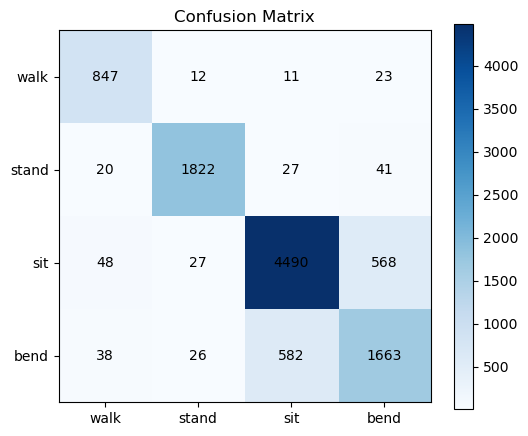

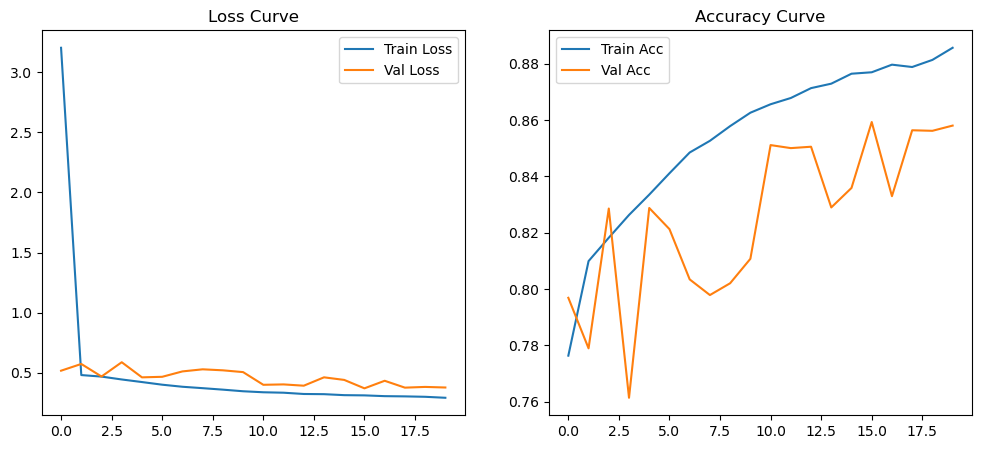

In [3]:
# ============================================================
# 1. Imports
# ============================================================
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import itertools

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

LABELS = ["walk", "stand", "sit", "bend"]   # 已过滤 lie


# ============================================================
# 2. Dataset
# ============================================================
# =============================================
# ✔ FINAL FIXED VERSION — PoseDataset（不会再报错）
# =============================================
class PoseDataset(Dataset):
    def __init__(self, X, Y, label_to_idx=None):
        """
        X: numpy array of shape (N, 32, 4)
        Y: numpy array of strings (e.g., "walk", "sit", ...)
        """

        # ----- 1) 保证 X 是 float32 -----
        if isinstance(X, np.ndarray):
            X = X.astype(np.float32)
        else:
            raise ValueError("X must be a numpy array")

        # ----- 2) 处理标签转换 -----
        if label_to_idx is None:
            # 自动生成标签映射
            uniq = sorted(list(set(Y.tolist())))
            label_to_idx = {lb: i for i, lb in enumerate(uniq)}

        # 保存映射（测试/验证也要用一致的）
        self.label_to_idx = label_to_idx

        # 将字符串标签转换为 int
        Y_idx = np.array([label_to_idx[y] for y in Y], dtype=np.int64)

        # ----- 3) 转成 tensor -----
        self.X = torch.tensor(X, dtype=torch.float32)   # (N, 32, 4)
        self.Y = torch.tensor(Y_idx, dtype=torch.long)  # (N,)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]



# ============================================================
# 3. Simple ST-GCN model（足够训练你的 32 点 3D pose）
# ============================================================
class STGCN(nn.Module):
    def __init__(self, num_class=4):
        super().__init__()
        self.gcn = nn.Sequential(
            nn.Conv2d(4, 64, kernel_size=(1,1)),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=(1,1)),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=(1,1)),
            nn.ReLU(),
        )
        self.fc = nn.Linear(256*32, num_class)

    def forward(self, x):  # x: (N,32,4)
        x = x.permute(0, 2, 1)        # -> (N,4,32)
        x = x.unsqueeze(-1)          # -> (N,4,32,1)
        x = self.gcn(x)              # -> (N,256,32,1)
        x = x.view(x.size(0), -1)    # -> (N,256*32)
        return self.fc(x)


# ============================================================
# 4. 加载 stgcn_dataset.npz
# ============================================================
data = np.load("data/stgcn_dataset.npz", allow_pickle=True)
trainX, trainY = data["trainX"], data["trainY"]
valX, valY     = data["valX"],   data["valY"]
testX, testY   = data["testX"],  data["testY"]

print("Shapes:")
print("Train:", trainX.shape, trainY.shape)
print("Val:  ", valX.shape, valY.shape)
print("Test: ", testX.shape, testY.shape)

train_loader = DataLoader(PoseDataset(trainX, trainY), batch_size=64, shuffle=True)
val_loader   = DataLoader(PoseDataset(valX,   valY),   batch_size=64)
test_loader  = DataLoader(PoseDataset(testX,  testY),  batch_size=64)


# ============================================================
# 5. Training Utils
# ============================================================
def evaluate(model, loader, criterion):
    model.eval()
    total, correct, loss_sum = 0, 0, 0
    with torch.no_grad():
        for X, Y in loader:
            X, Y = X.to(device), Y.to(device)
            out = model(X)
            loss_sum += criterion(out, Y).item()
            pred = out.argmax(1)
            correct += (pred == Y).sum().item()
            total += len(Y)
    return loss_sum/len(loader), correct/total


# ============================================================
# 6. Train
# ============================================================
model = STGCN(num_class=4).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_loss_list, val_loss_list = [], []
train_acc_list,  val_acc_list  = [], []

EPOCH = 20

print("\n===== Training =====")
for epoch in range(1, EPOCH+1):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for X, Y in train_loader:
        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()
        out = model(X)
        loss = criterion(out, Y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pred = out.argmax(1)
        correct += (pred == Y).sum().item()
        total += len(Y)

    # validation
    val_loss, val_acc = evaluate(model, val_loader, criterion)

    train_loss_list.append(total_loss/len(train_loader))
    val_loss_list.append(val_loss)
    train_acc_list.append(correct/total)
    val_acc_list.append(val_acc)

    print(f"Epoch {epoch} | Train Loss {train_loss_list[-1]:.4f} Acc {train_acc_list[-1]:.4f} "
          f"| Val Loss {val_loss:.4f} Acc {val_acc:.4f}")


# ============================================================
# 7. Test Evaluation
# ============================================================
model.eval()
all_pred, all_true = [], []

with torch.no_grad():
    for X, Y in test_loader:
        X = X.to(device)
        pred = model(X).argmax(1).cpu().numpy()
        all_pred.extend(pred)
        all_true.extend(Y.numpy())

print("\n===== TEST RESULTS =====")
print(classification_report(all_true, all_pred, target_names=LABELS))
print("Test Macro F1:", f1_score(all_true, all_pred, average="macro"))


# ============================================================
# 8. Confusion Matrix
# ============================================================
cm = confusion_matrix(all_true, all_pred)

plt.figure(figsize=(6,5))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks(range(4), LABELS)
plt.yticks(range(4), LABELS)

for i, j in itertools.product(range(4), range(4)):
    plt.text(j, i, cm[i, j], ha='center', va='center')

plt.show()


# ============================================================
# 9. Loss & Accuracy Curves
# ============================================================
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_loss_list, label="Train Loss")
plt.plot(val_loss_list, label="Val Loss")
plt.legend(); plt.title("Loss Curve")

plt.subplot(1,2,2)
plt.plot(train_acc_list, label="Train Acc")
plt.plot(val_acc_list, label="Val Acc")
plt.legend(); plt.title("Accuracy Curve")
plt.show()
